In [85]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
#import streamlit as st
import numpy as np
import plotly.graph_objects as go
import logging
import geopandas
import shapely
from geopy.geocoders import Nominatim
from scipy.spatial.distance import cdist
from shapely.wkt import loads
from functools import wraps
import time
import pickle
import contextily as ctx

In [194]:
def getPaths(route,gdStreets):
    path = []
    for k in range(len(route)-1):
        path.append(   geopandas.GeoDataFrame(gdStreets.loc[route[k],route[k+1]].loc[0]).T  )
    path1  = geopandas.GeoDataFrame(pd.concat(path),crs="EPSG:4326").to_crs(epsg=3857)
    viz = path1.buffer(100)
    path2  = geopandas.GeoDataFrame(pd.concat(path),crs="EPSG:4326")
    viz2 = path2.buffer(0.0005)
    return path1,viz, path2, viz2

In [236]:
with open('./data/Gf.pkl', 'rb') as input:
    G = pickle.load(input)
with open('./data/ToI.pkl', 'rb') as input:
    ToI = pickle.load(input)
with open('./data/LoI.pkl', 'rb') as input:
    LoI = pickle.load(input)
gdNodes,gdStreets = ox.utils_graph.graph_to_gdfs(G)
gdNodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [220]:
HOME = 2.3550362,48.8869476
WORK = 2.3709643,48.8657564
home = ox.distance.nearest_nodes(G, 2.3550362,48.8869476)
work = ox.distance.nearest_nodes(G, 2.3709643,48.8657564)


In [107]:
gdStreets["vLength"] = gdStreets.length / ( 1 + gdStreets.trees )

<ipython-input-107-54704fc0014c>:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdStreets["vLength"] = gdStreets.length / ( 1 + gdStreets.trees )


In [108]:
G = ox.utils_graph.graph_from_gdfs(gdNodes,gdStreets)

In [195]:
routeShort = nx.shortest_path(G, home, work, 'length')
routeTrees = nx.shortest_path(G, home, work, 'vLength')

In [196]:
pathS,vizS,pS,vS = getPaths(routeShort,gdStreets)
pathT,vizT,pT,vT = getPaths(routeTrees,gdStreets)

<ipython-input-194-a9998b7354eb>:4: PerformanceWarning:

indexing past lexsort depth may impact performance.

<ipython-input-194-a9998b7354eb>:8: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




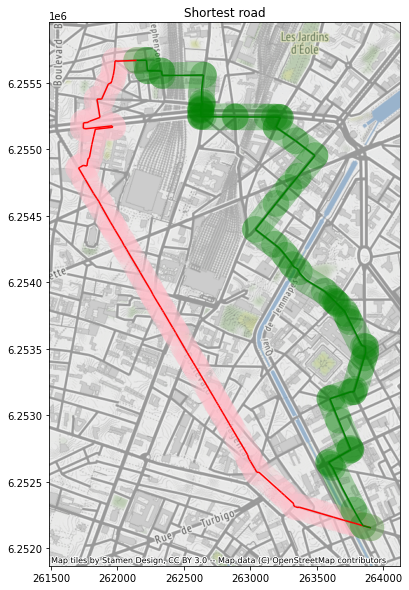

In [182]:
ax = vizS.plot(alpha=0.3,figsize=(10,10),color="pink")
pathS.plot(ax=ax, color="red")
#Adding trees
pathT.plot(ax=ax, color="green")
vizT.plot(ax=ax, alpha=0.3, color="green")
plt.title("Shortest road")
ctx.add_basemap(ax)

In [198]:
pS.geometry

0    LINESTRING (2.35488 48.88675, 2.35477 48.88675...
0    LINESTRING (2.35343 48.88673, 2.35342 48.88665...
0    LINESTRING (2.35336 48.88628, 2.35333 48.88617...
0      LINESTRING (2.35330 48.88609, 2.35322 48.88586)
0    LINESTRING (2.35322 48.88586, 2.35320 48.88584...
                           ...                        
0      LINESTRING (2.36889 48.86633, 2.36896 48.86632)
0    LINESTRING (2.36896 48.86632, 2.36945 48.86623...
0      LINESTRING (2.36954 48.86621, 2.36964 48.86619)
0    LINESTRING (2.36964 48.86619, 2.36981 48.86616...
0    LINESTRING (2.37018 48.86609, 2.37030 48.86607...
Name: geometry, Length: 92, dtype: geometry

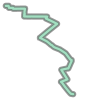

In [200]:
vT.unary_union

In [223]:
WORK

(2.3709643, 48.8657564)

In [266]:
def plot_path(origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    
    origin_point = (HOME) 
    destination_point = (WORK)
    # we will store the longitudes and latitudes in following list 
    lon = [] 
    lat = []  
    for i in routeTrees:
        point = G.nodes[i]
        lon.append(point['x'])
        lat.append(point['y'])
    
    
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Trees",
        mode = "lines",
        lon = lon,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    
    lon = []
    lat = []
    for i in routeShort:
        point = G.nodes[i]
        lon.append(point['x'])
        lat.append(point['y'])
    
    fig.add_trace(go.Scattermapbox(
        name = "Short",
        mode = "lines",
        lon = lon,
        lat = lat,
        marker = {'size': 8},
        line = dict(width = 4.5, color = 'red')))
    # adding source marker
    
    
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[0]],
        lat = [origin_point[1]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[0]],
        lat = [destination_point[1]],
        marker = {'size': 12, 'color':'green'}))
    
    Trees = ToI[ToI.within(vT.unary_union)]
    lats = [p.y for p in Trees.geometry]
    lons = [p.x for p in Trees.geometry]    
    fig.add_trace(go.Scattermapbox(
        name = "Trees",
        mode = "markers",
        lon = lons,
        lat = lats,
        marker = {'size': 10, 'color':"green", 'opacity':1}))

    
    Lights = LoI[LoI.within(vT.unary_union)]
    lats = [p.y for p in Lights.geometry]
    lons = [p.x for p in Lights.geometry]    
    fig.add_trace(go.Scattermapbox(
        name = "Lights",
        mode = "markers",
        lon = lons,
        lat = lats,
        marker = {'size': 3, 'color':"yellow", 'opacity':0.9}))
    
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(lon)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [267]:
plot_path(origin_point, destination_point)